In [2]:
import os
current_dir = %pwd
project_dir = os.path.dirname(current_dir)
%cd $project_dir

/data/dhryniewski/DataScientest/doc-classifier


/data/dhryniewski/DataScientest/doc-classifier/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from src import image_resize, image_merge, image_save, image_rotate
import matplotlib.pyplot as plt
pd.options.mode.copy_on_write = True

random.seed(42)
np.random.seed(42)

/tmp/ipykernel_3910160/3577745208.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [20]:
data_04_dir = "data/raw/data_04"
out_folder = "images_a4"

df = pd.read_csv(os.path.join(data_04_dir, "categories.csv"))

a4_height = 1000                        # La hauteur de la page A4 qu'on souhaite avoir.
a4_width = int(a4_height * (1 / 1.41))  # La largeur de notre page A4 (hauteur * ratio_page_A4).
dpi = a4_height / 3508 * 300            # Calcul le DPI pour une page A4 pour une hauteur de 1000 px.

In [3]:
df_passport = df[df["category"] == "passeport"]
df_cni = df[df["category"] == "national_identity_card"]

display(df_passport)
display(df_cni)

,category,country,width_(mm),height_(mm),page_category,image_name
0,passeport,Armenia,88.0,125.0,data_page,image_0000000.jpg
1,passeport,Armenia,88.0,125.0,other_page,image_0000001.jpg
2,passeport,Armenia,88.0,125.0,other_page,image_0000002.jpg
3,passeport,Armenia,88.0,125.0,other_page,image_0000003.jpg
4,passeport,Armenia,88.0,125.0,other_page,image_0000004.jpg
...,...,...,...,...,...,...
1574,passeport,United Kingdom,88.0,125.0,other_page,image_0001574.jpg
1575,passeport,Cameroon,88.0,125.0,data_page,image_0001575.jpg
1576,passeport,Cameroon,88.0,125.0,other_page,image_0001576.jpg
1577,passeport,Mexico,88.0,125.0,data_page,image_0001577.jpg


,category,country,width_(mm),height_(mm),page_category,image_name
27,national_identity_card,Bosnia and Herzegovina,84.0,58.0,front,image_0000027.jpg
28,national_identity_card,Bosnia and Herzegovina,84.0,58.0,back,image_0000028.jpg
29,national_identity_card,Bosnia and Herzegovina,86.0,54.0,front,image_0000029.jpg
30,national_identity_card,Bosnia and Herzegovina,86.0,54.0,back,image_0000030.jpg
99,national_identity_card,Belgium,85.0,54.0,front,image_0000099.jpg
...,...,...,...,...,...,...
1584,national_identity_card,Netherlands,86.0,54.0,back,image_0001584.jpg
1585,national_identity_card,Romania,86.0,54.0,front,image_0001585.jpg
1586,national_identity_card,Romania,86.0,54.0,back,image_0001586.jpg
1587,national_identity_card,Romania,105.0,74.0,front,image_0001587.jpg


In [4]:
from numpy.typing import ArrayLike
from typing import Tuple, List

def transform_matrix_points(points: ArrayLike, M: np.ndarray) -> ArrayLike:
    """Transform a set of 2D points using an affine transformation matrix.

    The function applies the given transformation matrix `M` to a set of 2D
    points. The points are represented as a list or array-like object with
    shape (N, 2), where N is the number of points.

    Args:
        points (array-like): An array-like object representing a set of 2D
            points.
        M (array-like): A 3x3 transformation matrix to be applied to the
            points.

    Returns:
        array-like: An array-like object containing the transformed 2D points.
    """
    if not isinstance(points, np.ndarray):
        points = np.array(points)

    if M.shape == (2, 3):
        M = np.vstack([M, [0,0,1]])

    points_dtype = points.dtype
    points_shape = points.shape
    points = points.astype(np.float32)
    points = points.reshape((-1,1,2))

    homg_points = np.array([[x, y, 1] for [[x, y]] in points]).T
    transf_homg_points = M.dot(homg_points)
    transf_homg_points /= transf_homg_points[2]
    points = transf_homg_points[:2].T

    return points.reshape(points_shape).astype(points_dtype)

def translate_points(points: ArrayLike, x: int, y: int) -> ArrayLike:
    """Translate a set of 2D points by a given offset along the x and y axes.

    The function applies a translation to the input set of 2D points represented
    as an array-like object with shape (N, 2), where N is the number of points.

    Args:
        points (ArrayLike): An array-like object representing a set of 2D points.
        x (int): The offset to be applied to the x-coordinates of the points.
        y (int): The offset to be applied to the y-coordinates of the points.

    Returns:
        ArrayLike: An array-like object containing the translated 2D points.
    """

    is_list = True if isinstance(points, list) else False

    points = np.array(points)
    points_dtype = points.dtype
    points_shape = points.shape
    reshape_points = points.reshape(-1)

    reshape_points[::2] = np.round(reshape_points[::2] + x)
    reshape_points[1::2] = np.round(reshape_points[1::2] + y)
    reshape_points = reshape_points.reshape(points_shape).astype(points_dtype)

    if is_list:
        reshape_points = reshape_points.tolist()

    return reshape_points

def is_point_inside(point: Tuple[float, float],
                    polygon_points: List[List[float]]) -> bool:
    """Check if a point is inside a polygon using the ray casting algorithm.

    Args:
        x (float): X-coordinate of the point.
        y (float): Y-coordinate of the point.
        polygon_points (List[List[float]]): List of vertices defining the
            polygon.

    Returns:
        bool: True if the point is inside the polygon, False otherwise.
    """
    # Ray casting algorithm
    num_points = len(polygon_points)
    inside = False
    x, y = point
    for i in range(num_points):
        x1, y1 = polygon_points[i]
        x2, y2 = polygon_points[(i + 1) % num_points]

        # Check if the point is to the left of the edge
        if ((y1 <= y < y2) or (y2 <= y < y1)) and (x > (x2 - x1) * (y - y1) / (y2 - y1) + x1):
            inside = not inside

    return inside

def on_segment(p, q, r):
    """ Vérifie si le point q est sur le segment pr """
    if q[0] <= max(p[0], r[0]) and q[0] >= min(p[0], r[0]) and q[1] <= max(p[1], r[1]) and q[1] >= min(p[1], r[1]):
        return True
    return False

def orientation(p, q, r):
    """ Calcule l'orientation de l'ordre des points (p, q, r)
        0 -> p, q et r sont colinéaires
        1 -> sens horaire
        2 -> sens antihoraire """
    val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
    if val == 0:
        return 0
    return 1 if val > 0 else 2

def do_intersect(p1, q1, p2, q2):
    """ Vérifie si les segments p1q1 et p2q2 se croisent """
    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)
    
    # Cas général
    if o1 != o2 and o3 != o4:
        return True
    
    # Cas particuliers
    if o1 == 0 and on_segment(p1, p2, q1):
        return True
    if o2 == 0 and on_segment(p1, q2, q1):
        return True
    if o3 == 0 and on_segment(p2, p1, q2):
        return True
    if o4 == 0 and on_segment(p2, q1, q2):
        return True
    
    return False

def polygons_intersect(polygon1, polygon2):
    """ Vérifie si deux polygones se croisent """
    for i in range(len(polygon1)):
        for j in range(len(polygon2)):
            p1 = polygon1[i]
            q1 = polygon1[(i + 1) % len(polygon1)]
            p2 = polygon2[j]
            q2 = polygon2[(j + 1) % len(polygon2)]
            if do_intersect(p1, q1, p2, q2):
                return True
    return False

## Création d'images A4 avec les cartes nationales d'identitées.

In [5]:
for i in ["image_0001588.jpg", "image_0001352.jpg", "image_0000500.jpg", "image_0000499.jpg",
          "image_0000498.jpg", "image_0000497.jpg", "image_0001183.jpg", "image_0001182.jpg",
          "image_0001184.jpg", "image_0001185.jpg", "image_0000629.jpg", "image_0000630.jpg",
          "image_0000631.jpg", "image_0000632.jpg", "image_0000633.jpg", "image_0000634.jpg",
          "image_0000635.jpg", "image_0000636.jpg", "image_0000637.jpg", "image_0000638.jpg",
          "image_0001353.jpg"]:
    idx = df_cni[df_cni['image_name'] == i].index[0]
    df_cni.drop(idx, inplace=True)

In [6]:
# Création de 1500 images
for i in tqdm(range(1500), total=1500):

    # Sélection d'un, deux ou trois documents.
    rows = df_cni.sample(random.choice([1,2,3]))

    # Création de la page A4 (blanche) :
    A4 = np.zeros((a4_height, a4_width, 3), dtype=np.uint8) + 255

    polygons = []
    for n, row in enumerate(rows.iloc):

        # Transformation de la hauteur et la largeur du document en pixels
        height = int(((row['height_(mm)'] / 25.4) * dpi))
        width = int(((row['width_(mm)'] / 25.4) * dpi))

        image = cv2.imread(os.path.join(data_04_dir, 'images', row['image_name']))
        img_h, img_w = image.shape[:2]
        # Vérification de l'orientation de l'image
        if img_w > img_h and height > width:
            width, height = height, width

        # Mise à l'échelle du document et création d'un masque.
        image = image_resize(image, (width, height), background_color=(255,255,255))
        mask = np.zeros_like(image, dtype=np.uint8) + 255

        # Rotation aléatoire du document, du masque et du polygone.
        h, w = image.shape[:2]
        poly = [[0, 0], [w, 0], [w, h], [0, h]]
        angle = random.uniform(-180, 180)
        image, M = image_rotate(image, angle, border_value=(255, 255, 255), auto_bound=True, return_matrix=True)
        mask = image_rotate(mask, angle, border_value=(0, 0, 0), auto_bound=True)
        poly = transform_matrix_points(poly, M)
        h, w = image.shape[:2]
        c = 0
        while True:
            # Positionnement aléatoire dans la page A4.
            x = random.randint(0, a4_width-w)
            y = random.randint(0, a4_height-h)
            translate_poly = translate_points(poly, x, y)

            if n == 0:
                A4 = image_merge(image, A4, mask, position=(x, y))
                polygons.append(translate_poly)
                break

            # Vérification de superposition des documents.
            is_pt_inside = any(is_point_inside(pt, translate_poly) for poly in polygons for pt in poly)
            is_poly_pt_inside = any(is_point_inside(pt, poly) for pt in translate_poly for poly in polygons)
            is_intersect = any(polygons_intersect(poly, translate_poly) for poly in polygons)
            if not is_pt_inside and not is_intersect and not is_poly_pt_inside:
                A4 = image_merge(image, A4, mask, position=(x, y))
                polygons.append(translate_poly)
                break

            # Compteur pour éviter la boucle infini
            c += 1
            if c == 100:
                break

    image_name = f"image_{i:07d}.jpg"
    image_save(os.path.join(data_04_dir, 'a4_cni', image_name), A4)


100%|██████████| 1500/1500 [00:42<00:00, 35.41it/s]


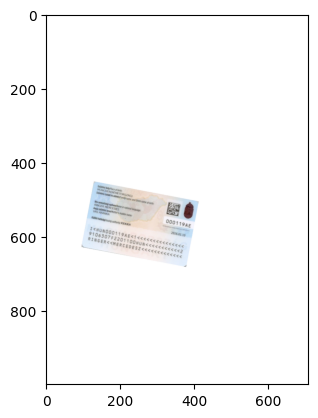

In [7]:
plt.imshow(A4[:,:,::-1])
plt.show()

## Création d'images A4 avec les passeports.

In [8]:
for i in ["image_0001090.jpg", "image_0001091.jpg"]:
    idx = df_passport[df_passport['image_name'] == i].index[0]
    df_passport.drop(idx, inplace=True)

In [9]:
df_data_page = df_passport[df_passport['page_category'] == "data_page"]
df_other_page = df_passport[df_passport['page_category'] == "other_page"]

# Création de 1500 images
for i in tqdm(range(1500), total=1500):

    # Création de la page A4 (blanche) :
    A4 = np.zeros((a4_height, a4_width, 3), dtype=np.uint8) + 255

    row = df_data_page.sample(1)

    other_pages = df_other_page[df_other_page['country'] == row['country'].values[0]]
    multi_page_p = 0.6 if len(other_pages) > 0 else 0.0

    # Transformation de la hauteur et la largeur du document en pixels
    data_height = int(((row['height_(mm)'].values[0] / 25.4) * dpi))
    data_width = int(((row['width_(mm)'].values[0] / 25.4) * dpi))

    image_data = cv2.imread(os.path.join(data_04_dir, 'images', row['image_name'].values[0]))
    img_data_h, img_data_w = image_data.shape[:2]

    # Vérification de l'orientation de l'image
    if img_data_w > img_data_h and data_height > data_width:
        data_width, data_height = data_height, data_width

    # Mise à l'échelle du document et création d'un masque.
    image_data = image_resize(image_data, (data_width, data_height), background_color=(255,255,255))

    if np.random.uniform() < multi_page_p:
        other_page = other_pages.sample(1)
        image_other = cv2.imread(os.path.join(data_04_dir, 'images', other_page['image_name'].values[0]))
        image_other = image_resize(image_other, (data_width, data_height), background_color=(255,255,255))

        image_height = image_data.shape[0] + image_other.shape[0]
        image = np.zeros((image_height, image_data.shape[1], 3), dtype=np.uint8)
        image[:image_other.shape[0], :] = image_other
        image[image_other.shape[0]:, :] = image_data
    else:
        image = image_data if np.random.uniform() < 0.5 else image_other

    mask = np.zeros_like(image, dtype=np.uint8) + 255

    h, w = image.shape[:2]
    poly = [[0, 0], [w, 0], [w, h], [0, h]]

    while True:
        # Rotation aléatoire du document, du masque et du polygone.
        angle = random.uniform(-40, 40)
        angle  = angle + 180 if np.random.uniform() > 0.5 else angle
        image_rot, M = image_rotate(image, angle, border_value=(255, 255, 255), auto_bound=True, return_matrix=True)
        mask_rot = image_rotate(mask, angle, border_value=(0, 0, 0), auto_bound=True)
        poly_rot = transform_matrix_points(poly, M)
        h, w = image_rot.shape[:2]
        if a4_width-w > 0:
            break

    # Positionnement aléatoire dans la page A4.
    x = random.randint(0, a4_width-w)
    y = random.randint(0, a4_height-h)
    translate_poly = translate_points(poly_rot, x, y)
    A4 = image_merge(image_rot, A4, mask_rot, position=(x, y))

    image_name = f"image_{i:07d}.jpg"
    image_save(os.path.join(data_04_dir, 'a4_passport', image_name), A4)

100%|██████████| 1500/1500 [00:44<00:00, 33.43it/s]


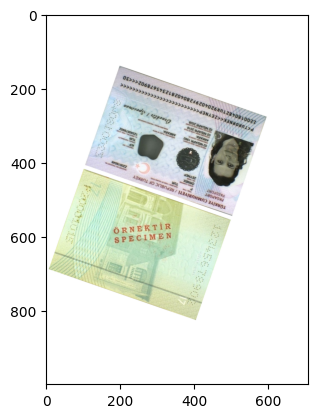

In [10]:
plt.imshow(A4[:,:,::-1])
plt.show()

# Creation de csv pour les entrainement avec les reseaux de nerones.

In [4]:
cat_dict = {
        "email": 0,
        "handwritten": 1,
        "invoice": 2,
        "national_identity_card": 3,
        "passeport": 4,
        "scientific_publication": 5
    }

all_data = {'image_path': [], 'category': []}

# data_01:
data_01_directory = "data/raw/data_01/images"
for pth in os.listdir(data_01_directory):
    img_pth = os.path.join(data_01_directory, pth)
    all_data['image_path'].append(img_pth)
    all_data['category'].append(2)

# data_04:
data_04_cni = "data/raw/data_04/a4_cni"
for pth in os.listdir(data_04_cni):
    img_pth = os.path.join(data_04_cni, pth)
    all_data['image_path'].append(img_pth)
    all_data['category'].append(3)

data_04_passport = "data/raw/data_04/a4_passport"
for pth in os.listdir(data_04_passport):
    img_pth = os.path.join(data_04_passport, pth)
    all_data['image_path'].append(img_pth)
    all_data['category'].append(4)

# data_03:
cats = pd.read_csv("data/raw/data_03/categories.csv")
cats = cats[cats['category'].isin(list(cat_dict.keys()))]
cats['image_name'] = cats['image_name'].apply(lambda x: os.path.join("data/raw/data_03/images", x))
cats['category'] = cats['category'].apply(lambda x: cat_dict[x])
all_data['image_path'] += list(cats['image_name'].values)
all_data['category'] += list(cats['category'].values)
df = pd.DataFrame(all_data)

In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=42)

In [8]:
train['category'].value_counts()

category
2    1408
4    1202
3    1195
0    1015
1    1007
5     989
Name: count, dtype: int64

In [9]:
test['category'].value_counts()

category
2    362
3    305
4    298
5    261
1    243
0    235
Name: count, dtype: int64

In [25]:
train.reset_index(drop=True, inplace=True)
train

,image_path,category
0,data/raw/data_03/images/image_0082282.tif,0
1,data/raw/data_04/a4_cni/image_0000630.jpg,3
2,data/raw/data_03/images/image_0072943.tif,5
3,data/raw/data_04/a4_cni/image_0000555.jpg,3
4,data/raw/data_03/images/image_0369742.tif,0
...,...,...
6811,data/raw/data_03/images/image_0182767.tif,0
6812,data/raw/data_03/images/image_0266538.tif,2
6813,data/raw/data_03/images/image_0062468.tif,0
6814,data/raw/data_04/a4_cni/image_0001246.jpg,3


In [26]:
test.reset_index(drop=True, inplace=True)
test

,image_path,category
0,data/raw/data_03/images/image_0112620.tif,1
1,data/raw/data_03/images/image_0009221.tif,0
2,data/raw/data_04/a4_passport/image_0000092.jpg,4
3,data/raw/data_04/a4_cni/image_0001117.jpg,3
4,data/raw/data_04/a4_cni/image_0001099.jpg,3
...,...,...
1699,data/raw/data_03/images/image_0014226.tif,5
1700,data/raw/data_03/images/image_0142379.tif,2
1701,data/raw/data_03/images/image_0258629.tif,0
1702,data/raw/data_03/images/image_0077670.tif,1


In [27]:
train.to_csv("data/processed/DL_train.csv", index=False)
test.to_csv("data/processed/DL_test.csv", index=False)